In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import logging
import os
import time
import math
from tqdm import tqdm
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import datetime

In [3]:
from torch.cuda.amp import autocast, GradScaler

In [4]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


In [6]:
class IntrusionDetectionDataset(Dataset):
    """Dataset class for IDS data."""
    
    def __init__(self, X_cnn, X_lstm, y):
        self.X_cnn = torch.FloatTensor(X_cnn)
        self.X_lstm = torch.FloatTensor(X_lstm)
        #self.y = torch.LongTensor(y)
        self.y = torch.LongTensor(y.values if isinstance(y, pd.Series) else y)

        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X_cnn[idx], self.X_lstm[idx], self.y[idx]


In [7]:
import pandas as pd

# Load datasetC
data_path = "C:/Users/athar/nids-xai/cic-collection.parquet"  # Replace with your actual file path
df = pd.read_parquet(data_path)

# Expected features
expected_features = [
    'Avg Packet Size', 'Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Variance',
    'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Std', 'Fwd Packet Length Mean',
    'Avg Fwd Segment Size', 'Flow Bytes/s', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean',
    'Fwd Packets/s', 'Flow Packets/s', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes',
    'Fwd Packets Length Total', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Subflow Fwd Packets'
]

# Check columns
actual_features = df.columns.tolist()
print("All columns in dataset:", actual_features)
print("\nExpected features present:")
for feat in expected_features:
    if feat in actual_features:
        print(f"{feat}: Present")
    else:
        print(f"{feat}: Missing")

# Check ClassLabel
if 'ClassLabel' in actual_features:
    print("\nClassLabel values:", df['ClassLabel'].unique())
else:
    print("\nClassLabel: Missing")

All columns in dataset: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'URG Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets', 'Fwd S

In [8]:
import torch
import torch.nn as nn

class HybridCNNBiLSTM(nn.Module):
    """
    Improved Hybrid CNN-BiLSTM model with enhanced regularization to combat overfitting.
    """
    def __init__(self, cnn_input_shape, lstm_input_shape, num_classes):
        super(HybridCNNBiLSTM, self).__init__()
        
        # CNN branch with Batch Normalization and Dropout2d for spatial dropout
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Calculate the flattened CNN output size after two pooling layers
        cnn_output_height = cnn_input_shape[1] // 4  # divided by 2 twice
        cnn_output_width = cnn_input_shape[2] // 4
        self.cnn_output_size = 64 * cnn_output_height * cnn_output_width
        
        # BiLSTM branch with dropout between layers
        self.lstm1 = nn.LSTM(
            input_size=lstm_input_shape[1],
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )
        # Dropout layer applied on LSTM outputs to prevent overfitting
        self.dropout_lstm = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(
            input_size=128,  # 64 (hidden) * 2 (bidirectional)
            hidden_size=32,
            batch_first=True,
            bidirectional=True
        )
        
        # Combined fully connected layers
        # Note: The BiLSTM output is 32*2 = 64 features (from last time step)
        combined_size = self.cnn_output_size + 64
        self.fc1 = nn.Linear(combined_size, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x_cnn, x_lstm):
        # CNN branch
        x1 = self.conv1(x_cnn)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.pool1(x1)
        x1 = self.dropout1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.relu(x1)
        x1 = self.pool2(x1)
        x1 = self.dropout2(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten
        
        # BiLSTM branch
        x2, _ = self.lstm1(x_lstm)
        x2 = self.dropout_lstm(x2)
        x2, _ = self.lstm2(x2)
        x2 = x2[:, -1, :]  # Use the output from the last time step
        
        # Feature fusion and classification
        combined = torch.cat((x1, x2), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

In [9]:
class IntrusionDetectionSystem:
    def __init__(self, config: Dict[str, Any]):
        """
        Initialize the IDS with configuration parameters.
        
        Args:
            config: Dictionary containing model configuration
        """
        self.config = config
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None  # Store feature names for XAI
        
    def load_data(self, filepath: str) -> pd.DataFrame:
        """
        Load and perform initial cleaning of the CICIDS2017 dataset.
        
        Args:
            filepath: Path to the Parquet file
            
        Returns:
            Cleaned DataFrame
        """
        try:
            logger.info("Loading pre-processed dataset...")
            print("\nReading parquet dataset file...")
            df = pd.read_parquet(filepath)
            labels_to_keep = ['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet']
            df = df[df['ClassLabel'].isin(labels_to_keep)]
            df = df.drop(columns='Label')
            df['ClassLabel'] = df['ClassLabel'].astype('category').cat.codes
            
            positive_correlation_features = [
                'Avg Packet Size', 'Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Variance',
                'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Std', 'Fwd Packet Length Mean',
                'Avg Fwd Segment Size', 'Flow Bytes/s', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean',
                'Fwd Packets/s', 'Flow Packets/s', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes',
                'Fwd Packets Length Total', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Subflow Fwd Packets'
            ]
            df = df[positive_correlation_features + ['ClassLabel']]
            self.feature_names = positive_correlation_features  # Save feature names
            
            logger.info(f"Loaded {len(df):,} rows and {len(df.columns):,} columns")
            logger.info(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
            return df
            
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise
            
    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the data for training.
        
        Args:
            df: Input DataFrame
            
        Returns:
            Tuple of (features, labels)
        """
        try:
            print("\nPreprocessing data...")
            X = df.drop('ClassLabel', axis=1)
            y = df['ClassLabel']
            print("Scaling features...")
            X_scaled = self.scaler.fit_transform(X)
            label_mapping = {0: 'Benign', 1: 'DoS', 2: 'DDoS', 3: 'Bruteforce', 4: 'Botnet'}
            unique_labels, counts = np.unique(y, return_counts=True)
            logger.info("\nClass distribution:")
            for encoded_label, count in zip(unique_labels, counts):
                original_label = label_mapping[encoded_label]
                logger.info(f"{original_label}: {count:,} samples")
            return X_scaled, y
            
        except Exception as e:
            logger.error(f"Error preprocessing data: {str(e)}")
            raise

    def reshape_data(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Reshape data for CNN and BiLSTM branches with memory efficiency.
        
        Args:
            X: Input features
            
        Returns:
            Tuple of (CNN_shaped_data, LSTM_shaped_data)
        """
        try:
            print("\nReshaping data for neural networks...")
            X = X.astype(np.float32)
            chunk_size = 10000
            num_chunks = (X.shape[0] + chunk_size - 1) // chunk_size
            features_sqrt = math.ceil(np.sqrt(X.shape[1]))
            padding_cnn = features_sqrt ** 2 - X.shape[1]
            timesteps = self.config['timesteps']
            if X.shape[1] % timesteps != 0:
                new_total = math.ceil(X.shape[1] / timesteps) * timesteps
                padding_lstm = new_total - X.shape[1]
            else:
                new_total = X.shape[1]
                padding_lstm = 0
            X_cnn_shape = (X.shape[0], 1, features_sqrt, features_sqrt)
            X_lstm_shape = (X.shape[0], timesteps, new_total // timesteps)
            X_cnn = np.zeros(X_cnn_shape, dtype=np.float32)
            X_lstm = np.zeros(X_lstm_shape, dtype=np.float32)
            for i in range(num_chunks):
                start_idx = i * chunk_size
                end_idx = min((i + 1) * chunk_size, X.shape[0])
                chunk = X[start_idx:end_idx]
                if padding_cnn > 0:
                    chunk_padded_cnn = np.pad(chunk, ((0, 0), (0, padding_cnn)), mode='constant')
                else:
                    chunk_padded_cnn = chunk.copy()
                X_cnn[start_idx:end_idx] = chunk_padded_cnn.reshape(-1, 1, features_sqrt, features_sqrt)
                if padding_lstm > 0:
                    chunk_padded_lstm = np.pad(chunk, ((0, 0), (0, padding_lstm)), mode='constant')
                else:
                    chunk_padded_lstm = chunk.copy()
                X_lstm[start_idx:end_idx] = chunk_padded_lstm.reshape(-1, timesteps, new_total // timesteps)
                del chunk, chunk_padded_cnn, chunk_padded_lstm
                if i % 10 == 0:
                    import gc
                    gc.collect()
                    print(f"Processed chunk {i+1}/{num_chunks}")
            return X_cnn, X_lstm
                
        except Exception as e:
            logger.error(f"Error reshaping data: {str(e)}")
            raise        
    
    def handle_class_imbalance(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Handle class imbalance using Focal Loss preparation.
        
        Args:
            X: Features
            y: Labels
            
        Returns:
            Tuple of (original_features, original_labels)
        """
        try:
            print("\nHandling class imbalance...")
            start_time = time.time()
            logger.info("Class distribution:")
            unique_labels, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique_labels, counts):
                logger.info(f"Class {label}: {count:,} samples")
            total_samples = len(y)
            n_classes = len(unique_labels)
            class_weights = {}
            for label, count in zip(unique_labels, counts):
                weight = total_samples / (n_classes * count)
                class_weights[int(label)] = weight
                logger.info(f"Class {label} weight: {weight:.4f}")
            self.class_weights = class_weights
            duration = time.time() - start_time
            logger.info(f"Class weight calculation completed in {duration:.2f} seconds")
            return X, y
                
        except Exception as e:
            logger.error(f"Error handling class imbalance: {str(e)}")
            raise
    
    def create_dataloaders(self, X_train_cnn, X_train_lstm, y_train, 
                         X_val_cnn, X_val_lstm, y_val,
                         X_test_cnn, X_test_lstm, y_test):
        """
        Create PyTorch DataLoaders for training, validation, and testing.
        
        Returns:
            Tuple of (train_loader, val_loader, test_loader)
        """
        try:
            print("\nCreating PyTorch DataLoaders...")
            train_dataset = IntrusionDetectionDataset(X_train_cnn, X_train_lstm, y_train)
            val_dataset = IntrusionDetectionDataset(X_val_cnn, X_val_lstm, y_val)
            test_dataset = IntrusionDetectionDataset(X_test_cnn, X_test_lstm, y_test)
            import platform
            is_windows = platform.system() == 'Windows'
            if is_windows:
                import torch.multiprocessing as mp
                mp.set_start_method('spawn', force=True)
            if is_windows:
                safe_workers = 0
            else:
                safe_workers = self.config.get('num_workers', 0)
            print(f"Using {safe_workers} DataLoader workers (adjusted for platform compatibility)")
            train_loader = DataLoader(
                train_dataset, 
                batch_size=self.config.get('batch_size'),
                shuffle=True,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            val_loader = DataLoader(
                val_dataset, 
                batch_size=self.config.get('batch_size'), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            test_loader = DataLoader(
                test_dataset, 
                batch_size=self.config.get('batch_size'), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            logger.info(f"Created DataLoaders with {len(train_loader)} training batches, "
                       f"{len(val_loader)} validation batches, and {len(test_loader)} test batches")
            return train_loader, val_loader, test_loader
            
        except Exception as e:
            logger.error(f"Error creating DataLoaders: {str(e)}")
            raise

    def train_and_evaluate(self, train_loader, val_loader, test_loader, cnn_input_shape, lstm_input_shape, num_classes):
        """Train the model and evaluate its performance using Automatic Mixed Precision."""
        print(cnn_input_shape)
        print(lstm_input_shape)
        print(num_classes)
        try:
            print("\nStarting model training with Automatic Mixed Precision...")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = HybridCNNBiLSTM(cnn_input_shape, lstm_input_shape, num_classes).to(device)
            optimizer = optim.Adam(model.parameters(), lr=self.config['learning_rate'], weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
            if self.config['balanced'] == False:
                class_weights = torch.FloatTensor([self.class_weights[i] for i in range(len(self.class_weights))]).to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
            else:
                criterion = nn.CrossEntropyLoss()
            use_amp = self.config.get('mixed_precision', False) and torch.cuda.is_available()
            if use_amp:
                print("Using Automatic Mixed Precision (AMP) for training")
                from torch.amp import autocast
                scaler = torch.cuda.amp.GradScaler()
            else:
                print("Using full precision for training")
                scaler = None
            print("Validating dataset for correct class indices...")
            try:
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(train_loader):
                    min_target = targets.min().item()
                    max_target = targets.max().item()
                    if min_target < 0 or max_target >= num_classes:
                        raise ValueError(f"Invalid targets in batch {batch_idx}: range [{min_target}, {max_target}], "
                                       f"should be [0, {num_classes-1}]")
                    if batch_idx >= 5:
                        break
                print("Dataset validation complete - no invalid class indices found")
            except Exception as e:
                logger.error(f"Dataset validation error: {str(e)}")
                raise
            history = []
            best_val_loss = float('inf')
            accumulation_steps = 8
            for epoch in range(self.config['epochs']):
                model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                                  desc=f"Epoch {epoch+1}/{self.config['epochs']}")
                optimizer.zero_grad()
                for batch_idx, (x_cnn, x_lstm, targets) in progress_bar:
                    try:
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            problematic_indices = torch.where((targets >= num_classes) | (targets < 0))[0]
                            logger.error(f"Invalid target values in batch {batch_idx}, indices: {problematic_indices.tolist()}")
                            continue
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        if not torch.isfinite(loss):
                            logger.error(f"Non-finite loss detected in batch {batch_idx}: {loss.item()}")
                            continue
                        normalized_loss = loss / accumulation_steps
                        if use_amp:
                            scaler.scale(normalized_loss).backward()
                        else:
                            normalized_loss.backward()
                        if (batch_idx + 1) % accumulation_steps == 0 or batch_idx + 1 == len(train_loader):
                            if use_amp:
                                scaler.unscale_(optimizer)
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                scaler.step(optimizer)
                                scaler.update()
                            else:
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                optimizer.step()
                            optimizer.zero_grad()
                        train_loss += loss.item()
                        _, predicted = outputs.max(1)
                        train_total += targets.size(0)
                        train_correct += predicted.eq(targets).sum().item()
                        progress_bar.set_postfix({
                            'loss': train_loss / (batch_idx + 1), 
                            'acc': 100. * train_correct / train_total
                        })
                        if batch_idx % 100 == 0:
                            torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    except Exception as e:
                        logger.error(f"Error in batch {batch_idx}: {str(e)}")
                        logger.error(f"Input shapes - CNN: {x_cnn.shape}, LSTM: {x_lstm.shape}, Targets: {targets.shape}")
                        try:
                            targets_cpu = targets.detach().cpu().numpy()
                            logger.error(f"Target unique values: {np.unique(targets_cpu)}")
                        except:
                            logger.error("Could not convert targets to CPU")
                        continue
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                with torch.no_grad():
                    for batch_idx, (x_cnn, x_lstm, targets) in enumerate(val_loader):
                        try:
                            if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                                logger.error(f"Invalid validation target values in batch {batch_idx}")
                                continue
                            x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                            if use_amp:
                                with autocast(device_type='cuda'):
                                    outputs = model(x_cnn, x_lstm)
                                    loss = criterion(outputs, targets)
                            else:
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                            val_loss += loss.item()
                            _, predicted = outputs.max(1)
                            val_total += targets.size(0)
                            val_correct += predicted.eq(targets).sum().item()
                        except Exception as e:
                            logger.error(f"Error in validation batch {batch_idx}: {str(e)}")
                            continue
                epoch_train_loss = train_loss / len(train_loader)
                epoch_train_acc = 100. * train_correct / train_total if train_total > 0 else 0
                epoch_val_loss = val_loss / len(val_loader)
                epoch_val_acc = 100. * val_correct / val_total if val_total > 0 else 0
                scheduler.step(epoch_val_loss)
                print(f"Epoch {epoch+1}/{self.config['epochs']} - "
                      f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
                      f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
                history.append({
                    'epoch': epoch + 1,
                    'train_loss': epoch_train_loss,
                    'train_acc': epoch_train_acc,
                    'val_loss': epoch_val_loss,
                    'val_acc': epoch_val_acc
                })
                timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                checkpoint_dir = self.config.get('checkpoint_dir', 'checkpoints')
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                    logger.info(f"Created checkpoint directory: {checkpoint_dir}")
                checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}_{timestamp}.pth')
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': epoch_val_loss,
                    'train_loss': epoch_train_loss,
                    'timestamp': timestamp
                }
                torch.save(checkpoint, checkpoint_path)
                if epoch_val_loss < best_val_loss:
                    best_val_loss = epoch_val_loss
                    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
                    best_checkpoint = {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': best_val_loss,
                        'class_mapping': {i: label for i, label in enumerate(['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet'])},
                        'config': self.config,
                        'scaler': self.scaler,
                        'timestamp': timestamp
                    }
                    torch.save(best_checkpoint, best_model_path)
                    logger.info(f"New best model saved at epoch {epoch} with validation loss: {best_val_loss:.4f}")
                if len(history) > 5:
                    recent_val_losses = [h['val_loss'] for h in history[-5:]]
                    if all(recent_val_losses[i] > recent_val_losses[i-1] for i in range(1, len(recent_val_losses))):
                        print("Early stopping due to increasing validation loss")
                        break
            best_model_path = os.path.join(self.config.get('checkpoint_dir', 'checkpoints'), 'best_model.pth')
            checkpoint = torch.load(best_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            all_predictions = []
            all_targets = []
            with torch.no_grad():
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(test_loader):
                    try:
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            logger.error(f"Invalid test target values in batch {batch_idx}")
                            continue
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        test_loss += loss.item()
                        _, predicted = outputs.max(1)
                        test_total += targets.size(0)
                        test_correct += predicted.eq(targets).sum().item()
                        all_predictions.extend(predicted.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    except Exception as e:
                        logger.error(f"Error in testing batch {batch_idx}: {str(e)}")
                        continue
            test_loss = test_loss / len(test_loader) if len(test_loader) > 0 else float('inf')
            test_acc = 100. * test_correct / test_total if test_total > 0 else 0
            print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
            return model, history
        
        except Exception as e:
            logger.error(f"Error during training and evaluation: {str(e)}")
            import traceback
            logger.error(f"Stack trace: {traceback.format_exc()}")
            raise
        
    def _plot_training_history(self, history):
        """Plot and save training history metrics."""
        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            ax1.plot([h['train_loss'] for h in history], label='Training Loss')
            ax1.plot([h['val_loss'] for h in history], label='Validation Loss')
            ax1.set_title('Loss Over Epochs')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)
            ax2.plot([h['train_acc'] for h in history], label='Training Accuracy')
            ax2.plot([h['val_acc'] for h in history], label='Validation Accuracy')
            ax2.set_title('Accuracy Over Epochs')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy (%)')
            ax2.legend()
            ax2.grid(True)
            plt.tight_layout()
            plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
            logger.info("Training history plot saved to 'training_history.png'")
        except Exception as e:
            logger.error(f"Error plotting training history: {str(e)}")
            
    def save_model(self, model, path="model"):
        """
        Save model weights and preprocessing objects separately.
        """
        import os
        import joblib
        from datetime import datetime
        import torch
        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(path, "model_weights.pth"))
        joblib.dump(self.scaler, os.path.join(path, "scaler.joblib"))
        joblib.dump(self.label_encoder, os.path.join(path, "label_encoder.joblib"))
        import json
        metadata = {
            "model_architecture": "HybridCNNBiLSTM",
            "cnn_input_shape": (1, 5, 5),
            "lstm_input_shape": (10, 2),
            "num_classes": 5,
            "feature_names": self.feature_names if self.feature_names else [],
            "class_mapping": {i: label for i, label in enumerate(["Benign", "DoS", "DDoS", "Bruteforce", "Botnet"])},
            "class_weights": self.class_weights if hasattr(self, 'class_weights') else {},
            "pytorch_version": torch.__version__,
            "training_date": datetime.now().isoformat(),
            "config": self.config
        }
        with open(os.path.join(path, "metadata.json"), "w") as f:
            json.dump(metadata, f, indent=4)
        print(f"Model assets saved to directory: {path}")
        return path

In [ ]:
# Set memory allocation config
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

config = {
    'data_path': 'cic-collection.parquet',
    'label_column': 'ClassLabel',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'timesteps': 10,
    'batch_size': 64,  # Reduced batch size
    'balanced': False
}

# Initialize IDS
ids = IntrusionDetectionSystem(config)

# Load and preprocess data
df = ids.load_data(config['data_path'])
X, y = ids.preprocess_data(df)

# Split data into train, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=config['test_size'],
    random_state=config['random_state'],
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=config['val_size'],
    random_state=config['random_state'],
    stratify=y_train_full
)

# Reshape data for CNN and LSTM
X_val_cnn, X_val_lstm = ids.reshape_data(X_val)

# Load best model
best_model_path = 'models/best_model.pth'
best_checkpoint = torch.load(best_model_path, map_location=device)
model = HybridCNNBiLSTM(cnn_input_shape=X_val_cnn.shape[1:], 
                        lstm_input_shape=X_val_lstm.shape[1:], 
                        num_classes=5).to(device)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.eval()

2025-04-19 23:35:15 - INFO - Loading pre-processed dataset...



Reading parquet dataset file...


2025-04-19 23:35:20 - INFO - Loaded 9,067,474 rows and 21 columns
2025-04-19 23:35:20 - INFO - Memory usage: 942.57 MB



Preprocessing data...
Scaling features...


2025-04-19 23:35:24 - INFO - 
Class distribution:
2025-04-19 23:35:24 - INFO - Benign: 7,186,189 samples
2025-04-19 23:35:24 - INFO - DoS: 145,968 samples
2025-04-19 23:35:24 - INFO - DDoS: 103,244 samples
2025-04-19 23:35:24 - INFO - Bruteforce: 1,234,729 samples
2025-04-19 23:35:24 - INFO - Botnet: 397,344 samples



Reshaping data for neural networks...
Processed chunk 1/146
Processed chunk 11/146
Processed chunk 21/146
Processed chunk 31/146
Processed chunk 41/146
Processed chunk 51/146
Processed chunk 61/146
Processed chunk 71/146
Processed chunk 81/146
Processed chunk 91/146
Processed chunk 101/146
Processed chunk 111/146
Processed chunk 121/146
Processed chunk 131/146
Processed chunk 141/146


C:\Users\athar\AppData\Local\Temp\ipykernel_21052\4249129817.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=

HybridCNNBiLSTM(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (lstm1): LSTM(2, 64, batch_first=True, bidirectional=True)
  (dropout_lstm): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)

In [11]:
import numpy as np

X_train_cnn, X_train_lstm = ids.reshape_data(X_train)
X_test_cnn, X_test_lstm = ids.reshape_data(X_test)

# Flatten and concatenate CNN + LSTM features
X_train_combined = np.concatenate((
    X_train_cnn.reshape(len(X_train_cnn), -1),
    X_train_lstm.reshape(len(X_train_lstm), -1)
), axis=1)

X_test_combined = np.concatenate((
    X_test_cnn.reshape(len(X_test_cnn), -1),
    X_test_lstm.reshape(len(X_test_lstm), -1)
), axis=1)



Reshaping data for neural networks...
Processed chunk 1/581
Processed chunk 11/581
Processed chunk 21/581
Processed chunk 31/581
Processed chunk 41/581
Processed chunk 51/581
Processed chunk 61/581
Processed chunk 71/581
Processed chunk 81/581
Processed chunk 91/581
Processed chunk 101/581
Processed chunk 111/581
Processed chunk 121/581
Processed chunk 131/581
Processed chunk 141/581
Processed chunk 151/581
Processed chunk 161/581
Processed chunk 171/581
Processed chunk 181/581
Processed chunk 191/581
Processed chunk 201/581
Processed chunk 211/581
Processed chunk 221/581
Processed chunk 231/581
Processed chunk 241/581
Processed chunk 251/581
Processed chunk 261/581
Processed chunk 271/581
Processed chunk 281/581
Processed chunk 291/581
Processed chunk 301/581
Processed chunk 311/581
Processed chunk 321/581
Processed chunk 331/581
Processed chunk 341/581
Processed chunk 351/581
Processed chunk 361/581
Processed chunk 371/581
Processed chunk 381/581
Processed chunk 391/581
Processed ch

In [12]:
cnn_flat_size = X_train_cnn.shape[1] * X_train_cnn.shape[2] * X_train_cnn.shape[3]
H, W = X_train_cnn.shape[2], X_train_cnn.shape[3]
T, F = X_train_lstm.shape[1], X_train_lstm.shape[2]

def lime_predict(x):
    x = torch.tensor(x, dtype=torch.float32).to(device)
    cnn_part = x[:, :cnn_flat_size].reshape(-1, 1, H, W)
    lstm_part = x[:, cnn_flat_size:].reshape(-1, T, F)
    model.eval()
    with torch.no_grad():
        logits = model(cnn_part, lstm_part)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [13]:
#%pip install lime

In [14]:
from lime.lime_tabular import LimeTabularExplainer

# Define feature names for combined input
feature_names = ids.feature_names + ['cnn_pad_{}'.format(i) for i in range(5)] + ids.feature_names
assert len(feature_names) == X_train_combined.shape[1], f"Expected {X_train_combined.shape[1]} feature names, got {len(feature_names)}"

explainer = LimeTabularExplainer(
    training_data=X_train_combined,
    feature_names=feature_names,
    class_names=['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet'],
    mode='classification'
)

Feature names: ['Avg Packet Size', 'Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Variance', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Std', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Flow Bytes/s', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Fwd Packets/s', 'Flow Packets/s', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes', 'Fwd Packets Length Total', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Subflow Fwd Packets']
Predicted probabilities: [9.9810445e-01 7.6171185e-05 2.7047121e-04 1.5819043e-05 1.5330502e-03]
Predicted class index: 0 (Benign)


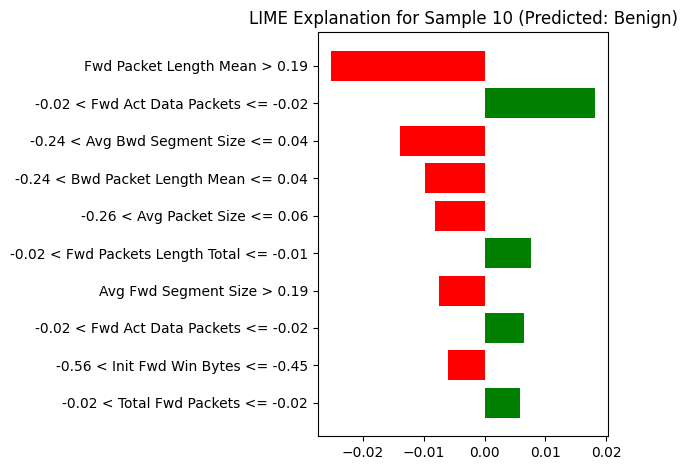


LIME Explanation for Sample 10 (Predicted: Benign):
Fwd Packet Length Mean > 0.19: -0.0253
-0.02 < Fwd Act Data Packets <= -0.02: 0.0182
-0.24 < Avg Bwd Segment Size <= 0.04: -0.0140
-0.24 < Bwd Packet Length Mean <= 0.04: -0.0098
-0.26 < Avg Packet Size <= 0.06: -0.0082
-0.02 < Fwd Packets Length Total <= -0.01: 0.0076
Avg Fwd Segment Size > 0.19: -0.0076
-0.02 < Fwd Act Data Packets <= -0.02: 0.0064
-0.56 < Init Fwd Win Bytes <= -0.45: -0.0060
-0.02 < Total Fwd Packets <= -0.02: 0.0058


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def generate_lime_explanation(sample_idx):
    """
    Generate and visualize LIME explanation for a given sample.
    
    Args:
        sample_idx (int): Index of the sample to explain.
        
    Returns:
        None: Displays and saves the explanation, prints detailed output.
    """
    # Define class names
    class_names = ['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet']
    
    try:
        # Verify feature names
        if not hasattr(ids, 'feature_names') or ids.feature_names is None:
            raise ValueError("ids.feature_names is not set. Check Cell [36].")
        print("Feature names:", ids.feature_names)
        
        # Generate LIME explanation
        exp = explainer.explain_instance(
            X_test_combined[sample_idx],
            lime_predict,
            num_features=10
        )
        
        # Compute predicted class manually
        probs = lime_predict(X_test_combined[sample_idx:sample_idx+1])  # Shape: (1, 5)
        predicted_class_idx = np.argmax(probs[0])                      # Get index of highest probability
        predicted_class_name = class_names[predicted_class_idx]
        print(f"Predicted probabilities: {probs[0]}")
        print(f"Predicted class index: {predicted_class_idx} ({predicted_class_name})")
        
        # Notebook visualization
        exp.show_in_notebook(show_table=True)
        
        # Save as plot
        fig = exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Sample {sample_idx} (Predicted: {predicted_class_name})")
        plt.tight_layout()
        plt.savefig(f'lime_explanation_sample_{sample_idx}.png', dpi=300)
        plt.show()
        
        # Detailed text output
        print(f"\nLIME Explanation for Sample {sample_idx} (Predicted: {predicted_class_name}):")
        for feature_name, weight in exp.as_list():
            print(f"{feature_name}: {weight:.4f}")
            
    except Exception as e:
        print(f"Error generating LIME explanation for sample {sample_idx}: {str(e)}")
        import traceback
        traceback.print_exc()

# Call the function for sample index 10
generate_lime_explanation(10)

In [16]:
#%pip install shap

In [17]:
#%pip install tensorflow

In [18]:
#%pip install captum


2025-04-19 23:37:22 - INFO - Analyzing sample 10 for class DoS
2025-04-19 23:37:22 - INFO - X_cnn shape: (1813495, 1, 5, 5), X_lstm shape: (1813495, 10, 2)
2025-04-19 23:37:22 - INFO - Labels shape: 1813495


Analyzing sample 10 for class DoS
True label: 0 (Benign)
Predicted label: Benign (confidence: 0.8645)


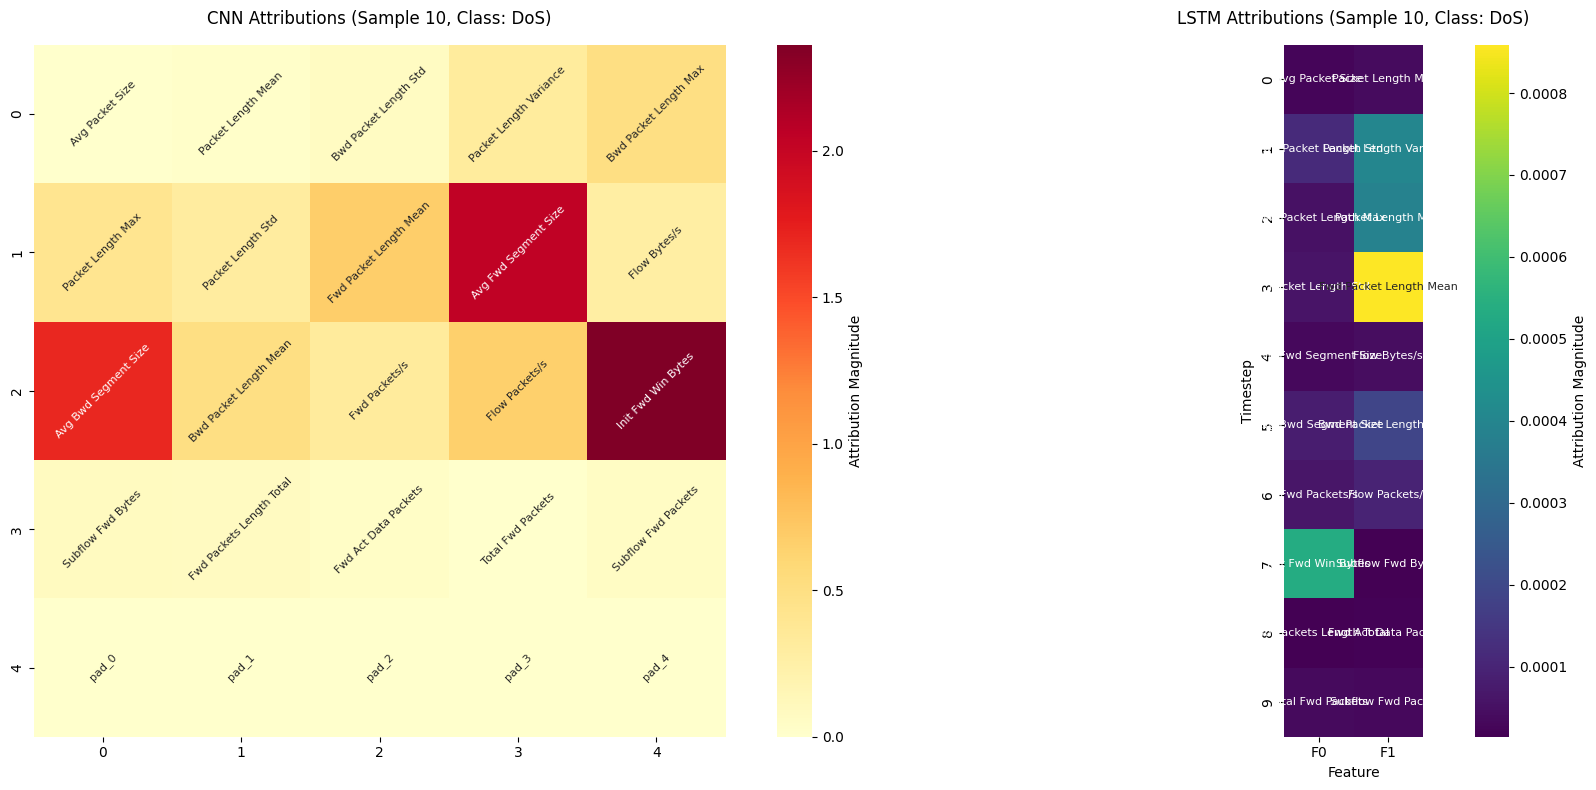

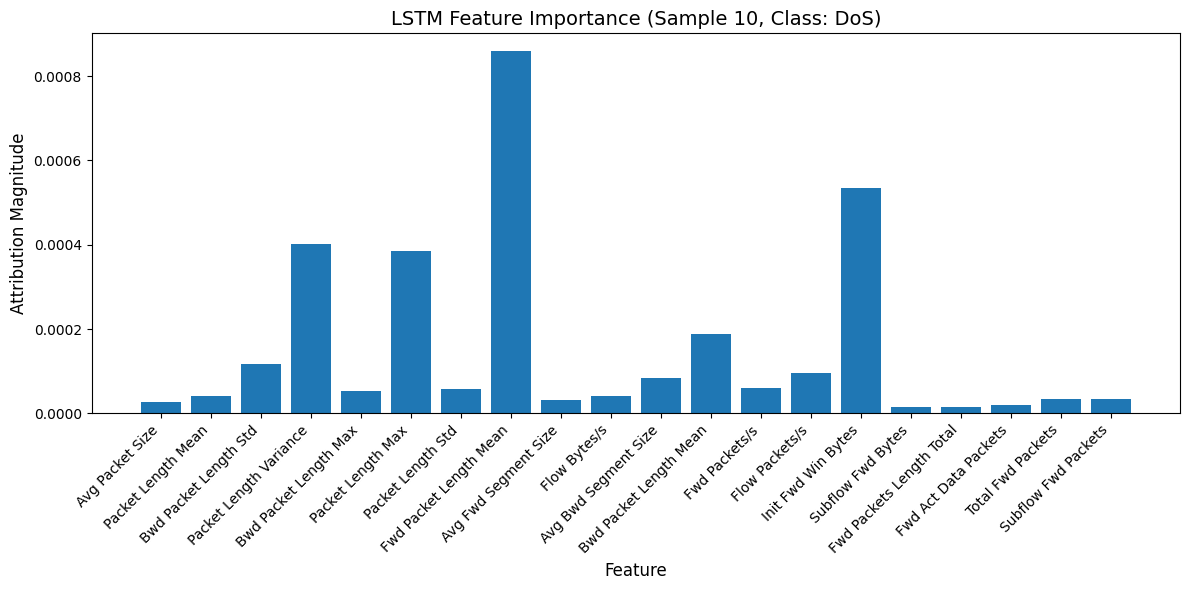


Analysis for sample 10, class DoS complete!


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def run_integrated_gradients_for_sample(sample_number, model, X_cnn, X_lstm, labels, class_name=None, device='cuda', class_names=None, steps=50):
    """
    Run Integrated Gradients analysis for a specific sample and target class.
    
    Args:
        sample_number: Index of the sample to analyze (int)
        model: Trained PyTorch model (HybridCNNBiLSTM)
        X_cnn: CNN input data (numpy array, shape: [N, 1, 5, 5])
        X_lstm: LSTM input data (numpy array, shape: [N, 10, 2])
        labels: True labels (numpy array or pandas Series)
        class_name: Target class name (str, e.g., 'DoS') or None for predicted class
        device: Device to run on ('cuda' or 'cpu')
        class_names: List of class names (default: ['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet'])
        steps: Number of interpolation steps for Integrated Gradients (default: 50)
    
    Returns:
        Dictionary with analysis results or None if failed
    """
    try:
        # Initialize class names
        if class_names is None:
            class_names = ['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet']
        
        # Validate class_name
        target_class = None
        if class_name is not None:
            if class_name not in class_names:
                logger.error(f"Invalid class_name: {class_name}. Must be one of {class_names}")
                return None
            target_class = class_names.index(class_name)
        
        # Validate inputs
        expected_cnn_shape = (1, 1, 5, 5)
        expected_lstm_shape = (1, 10, 2)
        logger.info(f"Analyzing sample {sample_number} for class {class_name if class_name else 'predicted'}")
        logger.info(f"X_cnn shape: {X_cnn.shape}, X_lstm shape: {X_lstm.shape}")
        logger.info(f"Labels shape: {labels.shape if isinstance(labels, np.ndarray) else len(labels)}")
        
        # Extract sample data
        if sample_number >= len(X_cnn):
            logger.error(f"Sample number {sample_number} out of range. Max index: {len(X_cnn)-1}")
            return None
        x_cnn = torch.tensor(X_cnn[sample_number:sample_number+1], dtype=torch.float32)
        x_lstm = torch.tensor(X_lstm[sample_number:sample_number+1], dtype=torch.float32)
        
        if x_cnn.shape != expected_cnn_shape:
            logger.error(f"Invalid CNN input shape: got {x_cnn.shape}, expected {expected_cnn_shape}")
            return None
        if x_lstm.shape != expected_lstm_shape:
            logger.error(f"Invalid LSTM input shape: got {x_lstm.shape}, expected {expected_lstm_shape}")
            return None
        
        x_cnn = x_cnn.to(device)
        x_lstm = x_lstm.to(device)
        
        # Get true label
        try:
            true_label = labels.iloc[sample_number] if hasattr(labels, 'iloc') else labels[sample_number]
        except Exception as e:
            logger.error(f"Failed to get true label: {e}")
            true_label = None
        
        # Get prediction
        model.eval()
        try:
            with torch.no_grad():
                output = model(x_cnn, x_lstm)
                pred_probs = torch.softmax(output, dim=1)
                pred_label = output.argmax(dim=1).item()
                # Set target_class to predicted class if not specified
                if target_class is None:
                    target_class = pred_label
                    class_name = class_names[target_class]
        except Exception as e:
            logger.error(f"Model prediction failed: {e}")
            return None
        
        # Print analysis info
        print(f"Analyzing sample {sample_number} for class {class_name}")
        print(f"True label: {true_label if true_label is not None else 'Unknown'} "
              f"({class_names[true_label] if true_label is not None and true_label < len(class_names) else 'N/A'})")
        print(f"Predicted label: {class_names[pred_label]} (confidence: {pred_probs[0, pred_label]:.4f})")
        
        # Compute Integrated Gradients
        try:
            # Initialize baselines
            baseline_cnn = torch.zeros_like(x_cnn, device=device)
            baseline_lstm = torch.zeros_like(x_lstm, device=device)
            
            integrated_grad_cnn = torch.zeros_like(x_cnn, device=device)
            integrated_grad_lstm = torch.zeros_like(x_lstm, device=device)
            
            # Interpolation steps
            for step in range(1, steps + 1):
                alpha = step / steps
                interpolated_cnn = baseline_cnn + alpha * (x_cnn - baseline_cnn)
                interpolated_lstm = baseline_lstm + alpha * (x_lstm - baseline_lstm)
                interpolated_cnn = interpolated_cnn.detach().requires_grad_(True)
                interpolated_lstm = interpolated_lstm.detach().requires_grad_(True)
                
                model.train()
                try:
                    with torch.no_grad():
                        for param in model.parameters():
                            param.requires_grad_(False)
                    output = model(interpolated_cnn, interpolated_lstm)
                    score = output[0, target_class]
                    score.backward()
                    if interpolated_cnn.grad is not None:
                        integrated_grad_cnn += interpolated_cnn.grad.detach()
                    if interpolated_lstm.grad is not None:
                        integrated_grad_lstm += interpolated_lstm.grad.detach()
                finally:
                    model.eval()
                    for param in model.parameters():
                        param.requires_grad_(True)
                
                interpolated_cnn.grad = None
                interpolated_lstm.grad = None
                torch.cuda.empty_cache()
            
            # Compute final attributions
            attribution_cnn = (x_cnn - baseline_cnn) * integrated_grad_cnn / steps
            attribution_lstm = (x_lstm - baseline_lstm) * integrated_grad_lstm / steps
        except Exception as e:
            logger.error(f"Integrated Gradients computation failed: {e}")
            return None
        
        # Visualize attributions
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
            
            # CNN heatmap
            attr_cnn = attribution_cnn.cpu().detach().numpy()[0, 0]  # Shape (5, 5)
            feature_names = ids.feature_names + ['pad_{}'.format(i) for i in range(5)]
            cnn_labels = np.array(feature_names[:25]).reshape(5, 5)
            sns.heatmap(
                np.abs(attr_cnn),
                annot=cnn_labels,
                fmt='s',
                cmap='YlOrRd',
                ax=ax1,
                cbar_kws={'label': 'Attribution Magnitude'},
                annot_kws={'size': 8, 'rotation': 45},
                square=True
            )
            ax1.set_title(f'CNN Attributions (Sample {sample_number}, Class: {class_name})', fontsize=12, pad=15)
            ax1.set_xticks(np.arange(5) + 0.5)
            ax1.set_yticks(np.arange(5) + 0.5)
            ax1.set_xticklabels(range(5), fontsize=10)
            ax1.set_yticklabels(range(5), fontsize=10)
            
            # LSTM heatmap
            attr_lstm = attribution_lstm.cpu().detach().numpy()[0]  # Shape (10, 2)
            lstm_labels = np.array(ids.feature_names).reshape(10, 2)
            sns.heatmap(
                np.abs(attr_lstm),
                annot=lstm_labels,
                fmt='s',
                cmap='viridis',
                ax=ax2,
                cbar_kws={'label': 'Attribution Magnitude'},
                annot_kws={'size': 8},
                square=True
            )
            ax2.set_title(f'LSTM Attributions (Sample {sample_number}, Class: {class_name})', fontsize=12, pad=15)
            ax2.set_xlabel('Feature', fontsize=10)
            ax2.set_ylabel('Timestep', fontsize=10)
            ax2.set_xticks(np.arange(2) + 0.5)
            ax2.set_yticks(np.arange(10) + 0.5)
            ax2.set_xticklabels(['F0', 'F1'], fontsize=10)
            ax2.set_yticklabels(range(10), fontsize=10)
            
            plt.tight_layout()
            plt.savefig(f'ig_heatmap_sample_{sample_number}_class_{class_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # LSTM feature importance bar plot
            feature_importance = np.abs(attr_lstm.reshape(-1))  # Flatten to (20,)
            plt.figure(figsize=(12, 6))
            plt.bar(ids.feature_names, feature_importance)
            plt.title(f'LSTM Feature Importance (Sample {sample_number}, Class: {class_name})', fontsize=14)
            plt.xlabel('Feature', fontsize=12)
            plt.ylabel('Attribution Magnitude', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.tight_layout()
            plt.savefig(f'ig_lstm_bar_sample_{sample_number}_class_{class_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            logger.error(f"Visualization failed: {e}")
            return None
        
        print(f"\nAnalysis for sample {sample_number}, class {class_name} complete!")
        return {
            'sample_number': sample_number,
            'true_label': true_label,
            'predicted_label': pred_label,
            'predicted_class': class_names[pred_label],
            'target_class': target_class,
            'target_class_name': class_name,
            'confidence': pred_probs[0, pred_label].item(),
            'attributions_cnn': attribution_cnn.cpu().numpy(),
            'attributions_lstm': attribution_lstm.cpu().numpy(),
            'input_cnn': x_cnn.cpu().numpy(),
            'input_lstm': x_lstm.cpu().numpy()
        }
    
    except Exception as e:
        logger.error(f"Error in Integrated Gradients analysis for sample {sample_number}, class {class_name}: {e}")
        return None

# Call the function for sample 10, class 'DoS'
result = run_integrated_gradients_for_sample(
    sample_number=10,
    model=model,
    X_cnn=X_test_cnn,
    X_lstm=X_test_lstm,
    labels=y_test,
    class_name='DoS',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)